# Multimodal (2D/3D) change detection for natural disaster response </h1>

**This tutorial will highlight the capabilities of multimodal satellite imagery in addressing some of nowadays most impacting societal challenges using open source tools from CNES (French space agency).**

In anticipation of the future CO3D mission, the French space agency (CNES) is currently developing open source tools for large-scale 3D data processing. With the arrival of 3D data on a more frequent basis, new use-cases for such data sources are emerging and enabling its applicability to pressing challenges such as improved crisis management in the aftermath of natural disasters. Change detection methodologies and their application to natural disaster response constitute a long-standing field within the remote sensing community, with initiatives like The International Charter Space and Major Disasters, open data programs of commercial satellite providers or annotated datasets like xview2 enabling a growing number of researchers and practitioners to continuously improve existing solutions. However, until now, the availability of post-event imagery, and thus related algorithms, have mainly been limited to monoscopic acquisitions, whereas with this type of constellations, a growing number of 3D data should also cover areas impacted by climate-related hazards.

In this context, CNES is currently working on the hybridization of 2D and 3D data for multimodal change detection. The proposed tutorial will present and teach some of this work being carried out by CNES through a pipeline that can be used for rapid mapping and longer-term risk and recovery management in order to help improving and enriching common existing approaches.

During this tutorial, you will discover how to:
- generate Digital Surface Models from sets of stereo satellite images using the CARS 3D reconstruction library : https://github.com/CNES/cars
- extract the Digital Terrain Models from Digital Surface Models through the Bulldozer library and derive a final Digital Height Model based on the obtained results : https://github.com/cnes/bulldozer
- extract semantic information from the 2D imagery by using classification models and spectral indices
- combine 2D and 3D change indicators in order to quantify and localize the potentially changed areas on a map
- visualize, filter and extract information on these changes using the uncertainties provided by the tools

## Clean

In [ ]:
!rm -rf outresults config.json config.yaml

## Installation (<10min)

In [ ]:
!python --version

In [ ]:
if 'google.colab' in str(get_ipython()):
    !echo "Running on CoLab"
    !wget https://raw.githubusercontent.com/cars-cnes/change-detection-for-natural-disaster-response/main/requirements.txt
    !pip install -r requirements.txt
else:
    !echo "Not running on CoLab"

In [ ]:
!cars -h

In [ ]:
!bulldozer -h

## Data

In [ ]:
from matplotlib import pyplot
import rasterio
from rasterio.plot import show

if 'google.colab' in str(get_ipython()):
    !echo "Running on CoLab"
    !mkdir data
    for pair in ["pre", "post"]:
        for mod in ["img", "color"]:
            for idx in range(2):
                for ext in [".geom", ".tif"]:
                    filename = "data/"+pair+"_event_"+mod+str(idx+1)+ext
                    filename = "https://raw.githubusercontent.com/cars-cnes/change-detection-for-natural-disaster-response/main/"+filename
                    !wget {filename} -P data/ 
else:
    !echo "Not running on CoLab"

fig, axs = pyplot.subplots(2, 2, figsize=(10,10))

for idx1, pair in enumerate(["pre", "post"]):
    for idx2 in range(2):
        with rasterio.open("data/"+pair+"_event_img"+str(idx2+1)+".tif") as src:
            show((src), ax=axs[idx1, idx2], cmap='gray', title=pair+"event"+str(idx2+1))

## Generate Digital Surface Models from sets of stereo satellite images
using the CARS 3D reconstruction library : https://github.com/CNES/cars


### Create your configuration file

In [ ]:
sensors = dict()
sensors["pre1"] = {"image": "data/pre_event_img1.tif",
                   "geomodel": "data/pre_event_img1.geom",
                   "color": "data/pre_event_color1.tif"}
sensors["pre2"] = {"image": "data/pre_event_img2.tif",
                   "geomodel": "data/pre_event_img2.geom",
                   "color": "data/pre_event_color2.tif"}

pairing = list()
pairing.append(["pre1", "pre2"])

inputs = {"sensors": sensors, "pairing": pairing}

config = {}
config["inputs"] = inputs
config["output"] = {"out_dir": "outresults/dsmpre"}

### Launch CARS - Python API

In [ ]:
from cars.pipelines.pipeline import Pipeline

pipeline = Pipeline("sensors_to_dense_dsm", config, os.getcwd())
pipeline.run()

### Let's see the results

#### Open & format output data

In [ ]:
import rasterio as rio
import numpy as np

with rio.open('outresults/dsmpre/dsm.tif') as dsm_reader:
  altitudes = dsm_reader.read(1)
  transform = dsm_reader.transform
  width, height = dsm_reader.width, dsm_reader.height
  cols, rows = np.meshgrid(np.arange(width), np.arange(height))

  # get coordinates to plot points cloud
  x_coords, y_coords = rio.transform.xy(transform, rows, cols, offset='center')
  x_coords = np.ravel(x_coords).T
  y_coords = np.ravel(y_coords).T
  z_coords = altitudes.reshape(-1).T

  nodata = dsm_reader.nodata

with rio.open('outresults/dsmpre/clr.tif') as clr_reader:
  colors = clr_reader.read().astype(float)
  # swap axes for imshow
  colors = np.swapaxes(colors[:3, :, :], 0, 2)

  # rescale colors
  for idx in range(3):
    colors[..., idx] = colors[..., idx].astype(float) / colors[..., idx].max()

# stack coords as points cloud
cloud = np.stack((x_coords, y_coords, z_coords), axis=1)
valid = cloud[:, 2] != nodata
cloud = cloud[valid]

# remove nodata altitudes
altitudes[altitudes==nodata] = np.nan

#### Imshow (2D)

In [ ]:
fig, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, figsize=(15, 9),
                              constrained_layout=True)

fig.suptitle("Altitudes and Colors as images", fontsize=15)
im1 = ax1.imshow(altitudes.T, cmap='jet', aspect="auto")
ax1.axis('off')
ax1.set_title('altitudes', fontsize=15)
ax2.imshow(colors, aspect="auto")
ax2.axis('off')
ax2.set_title('colors', fontsize=15)
fig.colorbar(im1, ax=ax1, shrink=0.7, aspect=30, orientation="horizontal", label="meters")
pyplot.show()

#### Scatter (3D)

In [ ]:
import plotly.graph_objects as go

inds = np.random.choice(range(cloud.shape[0]), 20000)
x = cloud[inds, 0]
y = cloud[inds, 1]
z = cloud[inds, 2]

layout = go.Layout(scene=dict(aspectmode="data"),
                   height=600, width=1200,
                   title=go.layout.Title(text="Points Cloud Viewer"))
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   marker=dict(
                                   size=2.5,
                                   color=z,
                                   colorscale='jet'))],
                layout=layout)
fig.show()

### Create your second configuration file

In [ ]:
import os, json
from cars.pipelines.pipeline import Pipeline

sensors = dict()
sensors["post1"] = {"image": "data/post_event_img1.tif",
                   "geomodel": "data/post_event_img1.geom",
                   "color": "data/post_event_color1.tif"}
sensors["post2"] = {"image": "data/post_event_img2.tif",
                   "geomodel": "data/post_event_img2.geom",
                   "color": "data/post_event_color2.tif"}

pairing = list()
pairing.append(["post1", "post2"])

inputs = {"sensors": sensors, "pairing": pairing}

config = {}
config["inputs"] = inputs
config["output"] = {"out_dir": "outresults/dsmpost"}

with open("config.json", "w") as f:  
    json.dump(config, f, indent=2)

In [ ]:
!cat config.json

### Launch CARS - Command line

In [ ]:
!cars config.json

## Extract the Digital Terrain Models from Digital Surface Models through the Bulldozer library
and derive a final Digital Height Model based on the obtained results : https://github.com/cnes/bulldozer


### Launch Bulldozer - Python API

In [ ]:
from bulldozer.pipeline.bulldozer_pipeline import dsm_to_dtm

dsm_to_dtm(dsm_path="outresults/dsmpre/dsm.tif",
           output_dir="outresults/dtmpre",
           nb_max_workers=1,
           uniform_filter_size=3)

In [ ]:
import yaml
config = {"dsm_path": "outresults/dsmpost/dsm.tif",
           "output_dir": "outresults/dtmpost",
           "nb_max_workers": 1,
           "uniform_filter_size": 3}

with open("config.yml", "w") as f:  
    yaml.dump(config, f)

In [ ]:
!cat config.yml

### Launch Bulldozer - Command line

In [ ]:
!bulldozer --conf config.yml

### Let's see the results

#### DSM, DTM, DHM profiles

In [ ]:
row_number = 550
pair = "pre"

from rasterio.windows import Window
fig, axs = pyplot.subplots(3, 3, figsize=(20, 20))

gs = axs[1, 0].get_gridspec()

for ax in axs[1, 0:]:
    ax.remove()

for ax in axs[2, 0:]:
    ax.remove()

axdstm = fig.add_subplot(gs[1, 0:])
axdhm = fig.add_subplot(gs[2, 0:])

for idx, out in enumerate(["dsm"+pair+"/dsm.tif", "dtm"+pair+"/DTM.tif", "dtm"+pair+"/DHM.tif"]):
    with rasterio.open(os.path.join("outresults", out)) as src:
        axs[0, idx].plot([0, src.width], [row_number, row_number],
                         color="red", linewidth=4)
        profiley = np.ravel(src.read(1, window=Window(0, row_number, src.width, 1)))
        profilex = np.arange(len(profiley))
        profilex = profilex[profiley!=src.nodata]
        profiley = profiley[profiley!=src.nodata]
        
        if os.path.basename(out) != "DHM.tif":
            axdstm.plot(profilex, profiley, label=os.path.basename(out).lower())
        else:
            axdhm.plot(profilex, profiley, label=os.path.basename(out).lower())

        array = src.read(1)
        array[array==src.nodata] = np.nan
        axs[0, idx].imshow(array, cmap='gray')
        axs[0, idx].set_title(os.path.basename(out).lower())
        
axdstm.legend()
axdhm.legend()
pyplot.show()

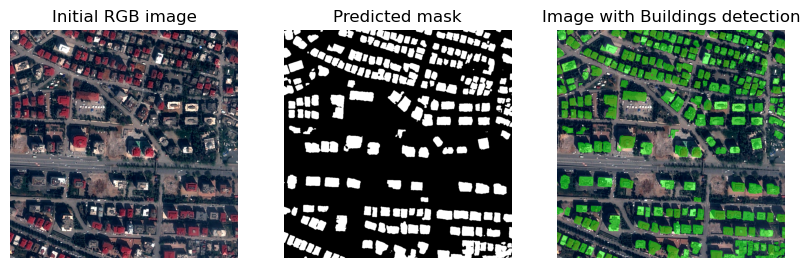

In [2]:
import building_detection

img = 'data/post_event_color1.tif'
weights = '/work/EOLAB/USERS/rouxmoj/Foss4G/Foss4G_weights.ckpt'

building_detection.run(img,weights)  